In [1]:
import os
import torch
import torch.nn as nn

In [2]:
ckpt_path = '/root/data/gaze_estimation/official.pth.tar'
ckpt = torch.load(ckpt_path, map_location='cpu')
ckpt.keys()

odict_keys(['vgg16.0.weight', 'vgg16.0.bias', 'vgg16.2.weight', 'vgg16.2.bias', 'vgg16.5.weight', 'vgg16.5.bias', 'vgg16.7.weight', 'vgg16.7.bias', 'vgg16.10.weight', 'vgg16.10.bias', 'vgg16.12.weight', 'vgg16.12.bias', 'vgg16.14.weight', 'vgg16.14.bias', 'vgg16.17.weight', 'vgg16.17.bias', 'vgg16.19.weight', 'vgg16.19.bias', 'vgg16.21.weight', 'vgg16.21.bias', 'vgg16.24.weight', 'vgg16.24.bias', 'vgg16.26.weight', 'vgg16.26.bias', 'vgg16.28.weight', 'vgg16.28.bias', 'FC1.weight', 'FC1.bias', 'FC2.weight', 'FC2.bias', 'FC3.weight', 'FC3.bias'])

In [ ]:
ckpt

In [8]:
# import VGG model
from torchvision import models

class VGG_Gaze_Estimator(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG_Gaze_Estimator, self).__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # discard FC layers
        self.vgg16 = self.vgg16.features

        self.FC1 = nn.Linear(512, 64, bias=True)
        self.FC2 = nn.Linear(64, 64, bias=True)
        self.FC3 = nn.Linear(64, 4, bias=True)

        self.leakly_relu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()

        # initialize weights
        nn.init.kaiming_normal_(self.FC1.weight.data)
        nn.init.constant_(self.FC1.bias.data, val=0)
        nn.init.kaiming_normal_(self.FC2.weight.data)
        nn.init.constant_(self.FC2.bias.data, val=0)
        nn.init.kaiming_normal_(self.FC3.weight.data)
        nn.init.constant_(self.FC3.bias.data, val=0)

    def forward(self, x, feature_out_layers: list = None):
        features = []
        print(self.vgg16)
        for i, layer in enumerate(self.vgg16):
            x = layer(x)
            if feature_out_layers is None: continue
            if i in feature_out_layers:
                features.append(x)
        #print(x.shape)
        x = x.mean(-1).mean(-1) # global average pooling
        #print(x.shape, "after global average pooling")
        x = self.leakly_relu(self.FC1(x))
        x = self.leakly_relu(self.FC2(x))
        x = self.tanh(self.FC3(x))
        x = torch.pi * x * 0.5
        gaze_estimate = x[:, :2]
        head_estimate = x[:, 2:]
        return gaze_estimate, head_estimate, features \
            if feature_out_layers is not None \
            else None

# ---

test_model = VGG_Gaze_Estimator()
#test_model.state_dict()

In [9]:
test_model.load_state_dict(ckpt, strict=True)
#test_model.state_dict()

<All keys matched successfully>

In [10]:
test_model.eval()
test_X = torch.randn(1, 3, 128, 128)
test_out = test_model(test_X, feature_out_layers=[3, 8, 15, 22, 29, 30])
print(len(test_out))
for i, layer in enumerate(test_out[-1]):
    print(f"layer {[3, 8, 15, 22, 29, 30][i]}: {layer.shape}")

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [14]:
test_model.eval()
test_X = torch.randn(1, 3, 128, 128)
test_out = test_model(test_X, feature_out_layers=[15, 22, 30])
print(len(test_out))
for i, layer in enumerate(test_out[-1]):
    print(f"layer {[15, 22, 30][i]}: {layer.shape}")

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [15]:
test_model.eval()
test_X = torch.randn(4, 3, 128, 128)
test_out = test_model(test_X, feature_out_layers=[i for i in range(31)])
print(len(test_out))
for i, layer in enumerate(test_out[-1]):
    print(f"layer {[j for j in range(31)][i]}: {layer.shape}")

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [27]:
import dataset
from torch.utils.data import DataLoader
gazeCaptureDataset = dataset.HDFDataset(
    hdf_file_path='/root/data/dataset_prep/faze_preprocess/outputs_sted/GazeCapture.h5',
    get_2nd_sample=True,
)
dataloader = DataLoader(
        gazeCaptureDataset,
        batch_size=4,
        shuffle=True,
        num_workers=8
    )

In [28]:
next(iter(dataloader))

{'key': ['03404', '02269', '01231', '01104'],
 'image_a': tensor([[[[-0.2000, -0.1529, -0.1137,  ...,  0.7333,  0.7490,  0.5843],
           [-0.2314, -0.1765, -0.1294,  ...,  0.7569,  0.7412,  0.5608],
           [-0.3804, -0.1765, -0.2235,  ...,  0.7569,  0.7412,  0.5843],
           ...,
           [ 0.9216,  0.8980,  0.9137,  ...,  0.9529,  0.9529,  0.9373],
           [ 0.8980,  0.9059,  0.9059,  ...,  0.9529,  0.9373,  0.9294],
           [ 0.8824,  0.8902,  0.9137,  ...,  0.9529,  0.9529,  0.9843]],
 
          [[-0.3490, -0.3176, -0.3255,  ...,  0.6941,  0.7098,  0.5529],
           [-0.3961, -0.3647, -0.3255,  ...,  0.7255,  0.7098,  0.5529],
           [-0.5294, -0.3333, -0.4118,  ...,  0.7255,  0.7098,  0.5765],
           ...,
           [ 0.9294,  0.8980,  0.9137,  ...,  0.9529,  0.9529,  0.9373],
           [ 0.9059,  0.8980,  0.9137,  ...,  0.9529,  0.9373,  0.9294],
           [ 0.8745,  0.8824,  0.9059,  ...,  0.9529,  0.9529,  0.9843]],
 
          [[-0.3961, -0.3569,

2023-05-08 22:48:46,414 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


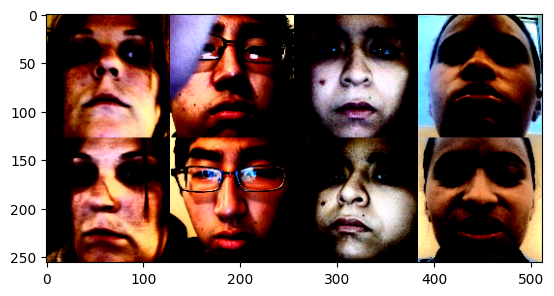

In [39]:
batch = next(iter(dataloader))
batch_a = batch['image_a'].permute(0, 2, 3, 1)
batch_b = batch['image_b'].permute(0, 2, 3, 1)

final = torch.cat((batch_a, batch_b), dim=1)
final = torch.cat((tuple(final)), dim=1)

plt.imshow(final)

2023-05-08 23:07:16,874 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


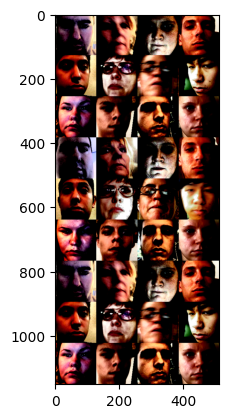

In [43]:
num_batch = 3
img_list = [next(iter(dataloader)) for i in range(num_batch)]
img_a_list = [img['image_a'] for img in img_list]
img_b_list = [img['image_b'] for img in img_list]
img_c_list = [img['image_a'] for img in img_list]

def concatenate_horizontal(batch_images):
    images = batch_images.permute(0, 2, 3, 1)
    horizontal_concat = torch.cat(tuple(images), dim=1)
    return horizontal_concat

img_a_horizontal = [concatenate_horizontal(batch) for batch in img_a_list]
img_b_horizontal = [concatenate_horizontal(batch) for batch in img_b_list]
img_c_horizontal = [concatenate_horizontal(batch) for batch in img_c_list]

final_image = torch.cat((
    img_a_horizontal +
    img_b_horizontal +
    img_c_horizontal
), dim=0
)
plt.imshow(final_image)

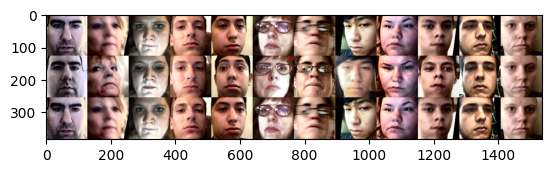

In [61]:
import numpy as np
import PIL
from torchvision.utils import make_grid
def return_image(images, gh, gw, H, W):
    np_imgs = []
    for i, image in enumerate(images):
        image = images[i][None,:,:]
        image = (image.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8).cpu().numpy()
        np_imgs.append(np.asarray(PIL.Image.fromarray(image[0], 'RGB').resize((H,W),PIL.Image.LANCZOS)))
    np_imgs = np.stack(np_imgs)
    np_imgs = np_imgs.reshape(gh,gw,H,W,3)
    np_imgs = np_imgs.transpose(0,2,1,3,4)
    np_imgs = np_imgs.reshape(gh*H, gw*W, 3)
    return np_imgs

result = torch.cat(img_a_list + img_b_list + img_c_list, dim=0)
#return_image(result, 3, 12, 128, 128).shape
plt.imshow(return_image(result, 3, 12, 128, 128))

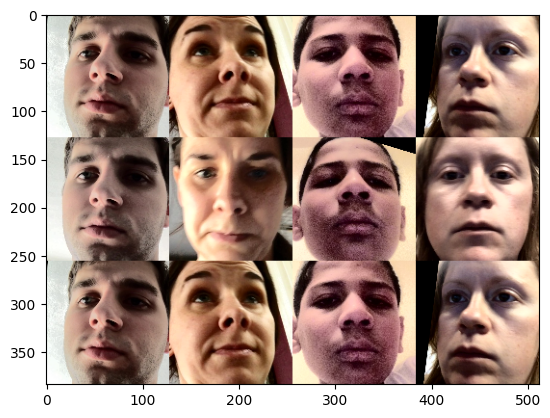

In [62]:
batch = next(iter(dataloader))
batch_a = batch['image_a']
batch_b = batch['image_b']
batch_c = batch['image_a']

result = torch.cat((batch_a, batch_b, batch_c), dim=0)
plt.imshow(return_image(result, 3, 4, 128, 128))

2023-05-08 22:48:01,222 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


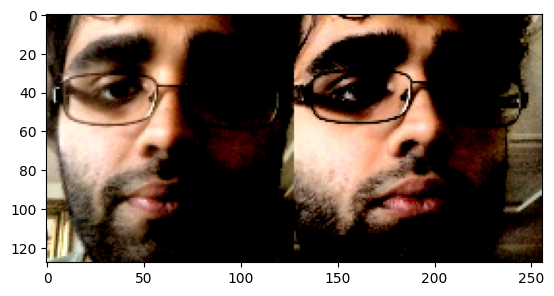

In [38]:
plt.imshow(torch.cat([gazeCaptureDataset[0]['image_a'], gazeCaptureDataset[0]['image_b']], dim=2).permute(1, 2, 0))

2023-05-08 16:31:13,107 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


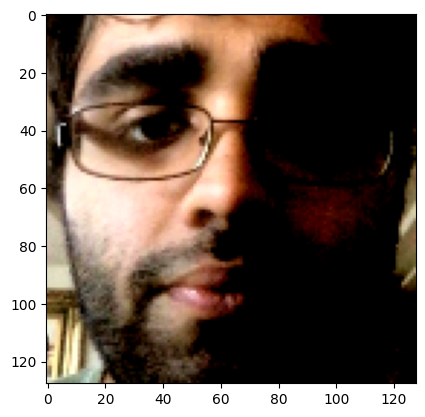

In [20]:
import matplotlib.pyplot as plt
plt.imshow(gazeCaptureDataset[0]['image_a'].permute(1, 2, 0))

In [9]:
test_img = gazeCaptureDataset[1]['image_a']
test_model.eval()
test_out = test_model(test_img.unsqueeze(0), feature_out_layers=None)
test_out

(tensor([[-0.2050,  0.0359]], grad_fn=<SliceBackward0>),
 tensor([[0.2640, 0.0097]], grad_fn=<SliceBackward0>),
 None)

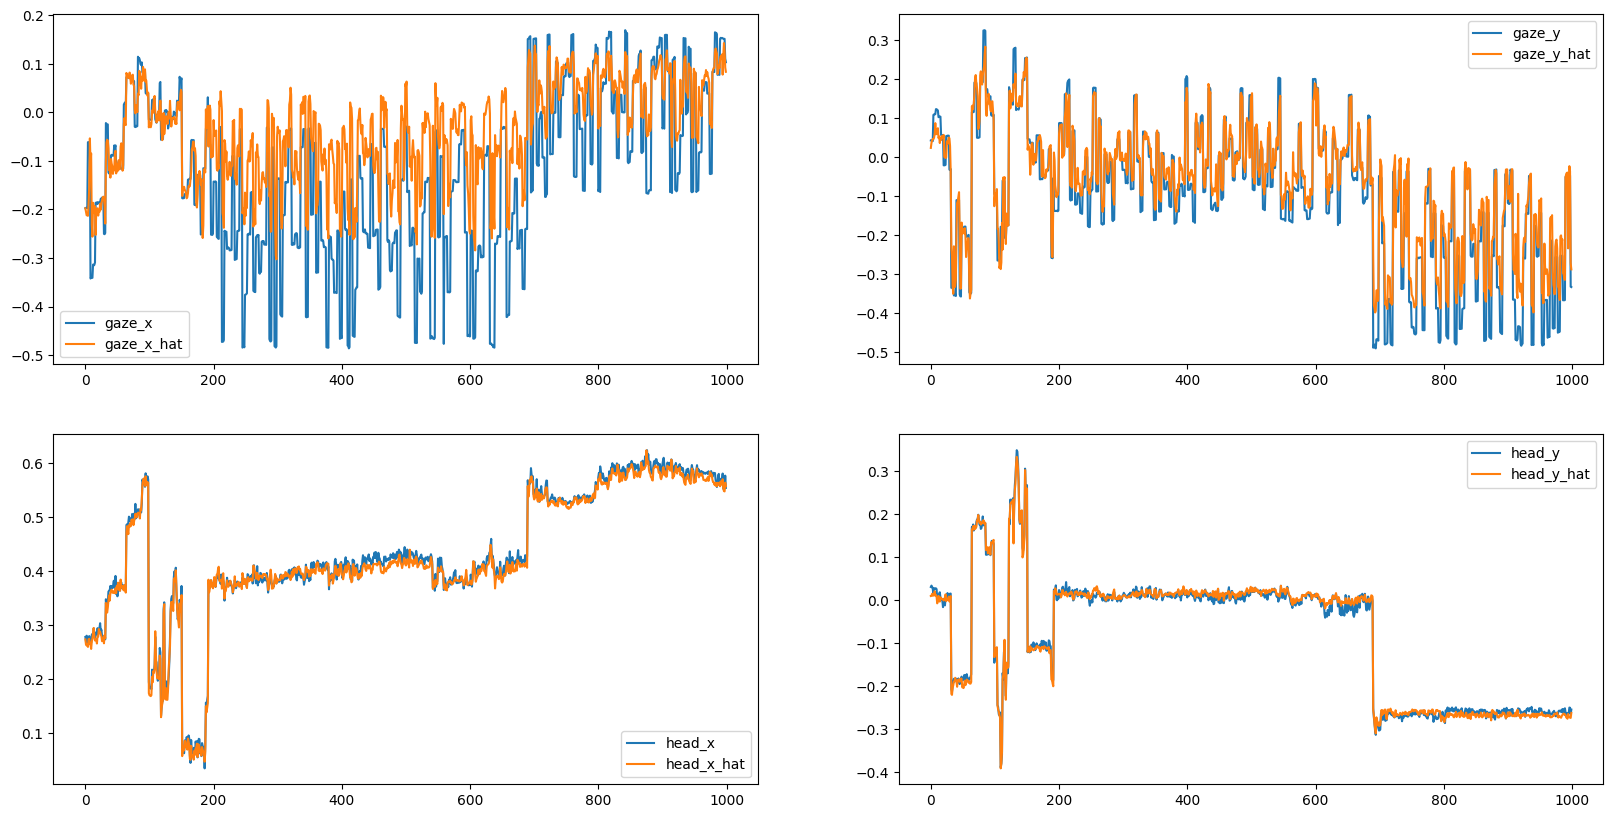

In [10]:
num_samples = 1000
# calculate difference between ground truth and estimated gaze/head angles
import numpy as np
import pandas as pd

df = pd.DataFrame(columns=['gaze_x', 'gaze_x_hat', 'gaze_y', 'gaze_y_hat', 'head_x', 'head_x_hat', 'head_y', 'head_y_hat'])
for i in range(num_samples):
    sample = gazeCaptureDataset[i]
    img = sample['image_a'].unsqueeze(0)
    gaze = sample['gaze_a'].numpy()
    head = sample['head_a'].numpy()
    gaze_hat, head_hat, _ = test_model(img, feature_out_layers=None)
    gaze_hat = gaze_hat.squeeze(0).detach().numpy()
    head_hat = head_hat.squeeze(0).detach().numpy()
    df.loc[i] = [gaze[0], gaze_hat[0], gaze[1], gaze_hat[1], head[0], head_hat[0], head[1], head_hat[1]]

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(df['gaze_x'], label='gaze_x')
plt.plot(df['gaze_x_hat'], label='gaze_x_hat')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df['gaze_y'], label='gaze_y')
plt.plot(df['gaze_y_hat'], label='gaze_y_hat')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df['head_x'], label='head_x')
plt.plot(df['head_x_hat'], label='head_x_hat')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df['head_y'], label='head_y')
plt.plot(df['head_y_hat'], label='head_y_hat')
plt.legend()

In [11]:
# ---
import torch.nn.functional as F
def nn_angular_distance(a, b):
    sim = F.cosine_similarity(a, b, eps=1e-6)
    sim = F.hardtanh(sim, -1.0, 1.0)
    return torch.acos(sim) * (180 / np.pi)

def pitchyaw_to_vector(pitchyaws):
    sin = torch.sin(pitchyaws)
    cos = torch.cos(pitchyaws)
    return torch.stack([cos[:, 0] * sin[:, 1], sin[:, 0], cos[:, 0] * cos[:, 1]], 1)


def gaze_angular_loss(y, y_hat, reduction='mean'):
    y = pitchyaw_to_vector(y)
    y_hat = pitchyaw_to_vector(y_hat)
    loss = nn_angular_distance(y, y_hat)
    if reduction == 'mean':
        loss = torch.mean(loss)
    elif reduction == 'sum':
        loss = torch.sum(loss)
    else:
        print("assuming reduction is None")
    return loss


assuming reduction is None


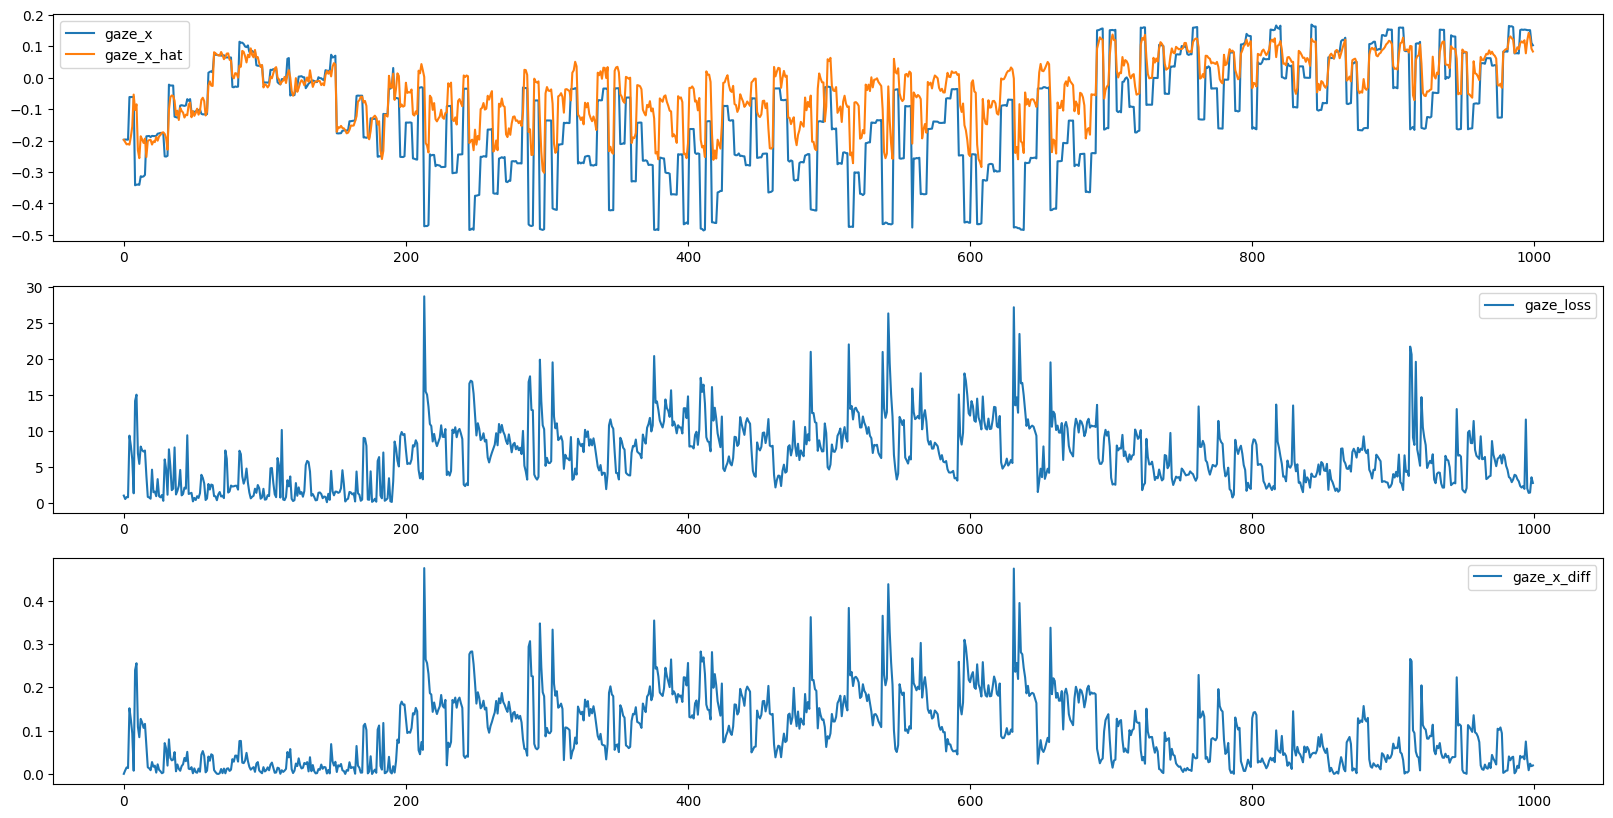

In [12]:
gaze_truth = torch.tensor(df[['gaze_x', 'gaze_y']].values)
gaze_hat = torch.tensor(df[['gaze_x_hat', 'gaze_y_hat']].values)
gaze_losses = gaze_angular_loss(gaze_truth, gaze_hat, reduction=None)
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(df['gaze_x'], label='gaze_x')
plt.plot(df['gaze_x_hat'], label='gaze_x_hat')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(gaze_losses, label='gaze_loss')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(np.abs(df['gaze_x'] - df['gaze_x_hat']), label='gaze_x_diff')
plt.legend()

gaze estimation network needs to be fine-tuned on GazeCapture dataset

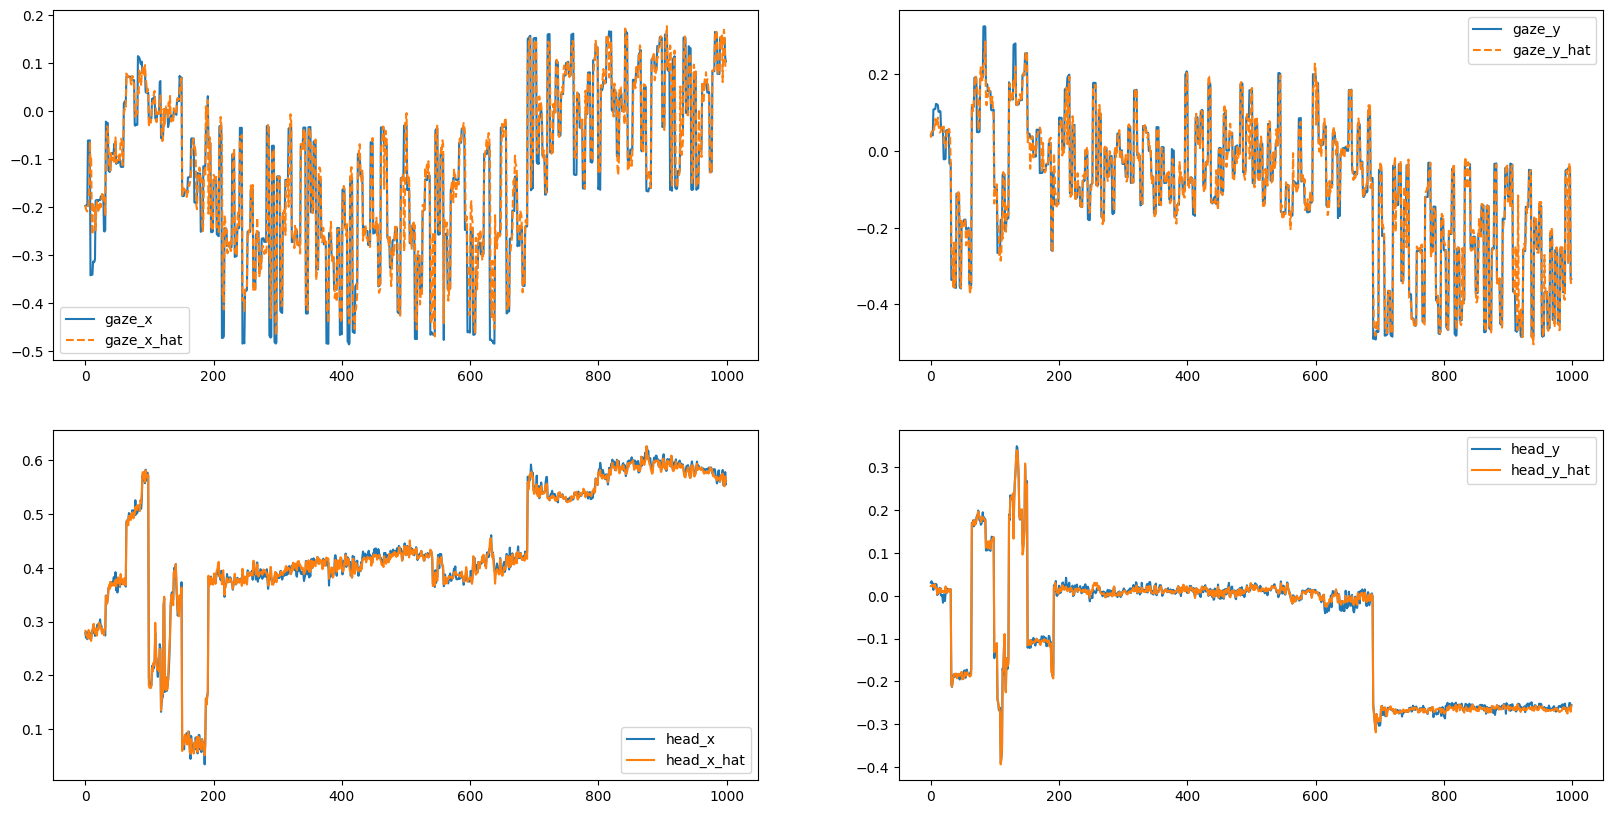

In [20]:
# post-finetune
final_pth = '/root/data/gaze_estimation/at_step_0069999_vggFreezeFalse.pth.tar'
ckpt = torch.load(final_pth, map_location='cpu')
test_model.load_state_dict(ckpt, strict=True)

test_model.eval()
num_samples = 1000
# calculate difference between ground truth and estimated gaze/head angles
import numpy as np
import pandas as pd

df = pd.DataFrame(columns=['gaze_x', 'gaze_x_hat', 'gaze_y', 'gaze_y_hat', 'head_x', 'head_x_hat', 'head_y', 'head_y_hat'])
for i in range(num_samples):
    sample = gazeCaptureDataset[i]
    img = sample['image_a'].unsqueeze(0)
    gaze = sample['gaze_a'].numpy()
    head = sample['head_a'].numpy()
    gaze_hat, head_hat, _ = test_model(img, feature_out_layers=None)
    gaze_hat = gaze_hat.squeeze(0).detach().numpy()
    head_hat = head_hat.squeeze(0).detach().numpy()
    df.loc[i] = [gaze[0], gaze_hat[0], gaze[1], gaze_hat[1], head[0], head_hat[0], head[1], head_hat[1]]

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(df['gaze_x'], label='gaze_x')
plt.plot(df['gaze_x_hat'], label='gaze_x_hat', linestyle='--')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df['gaze_y'], label='gaze_y')
plt.plot(df['gaze_y_hat'], label='gaze_y_hat', linestyle='--')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df['head_x'], label='head_x')
plt.plot(df['head_x_hat'], label='head_x_hat')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df['head_y'], label='head_y')
plt.plot(df['head_y_hat'], label='head_y_hat')
plt.legend()


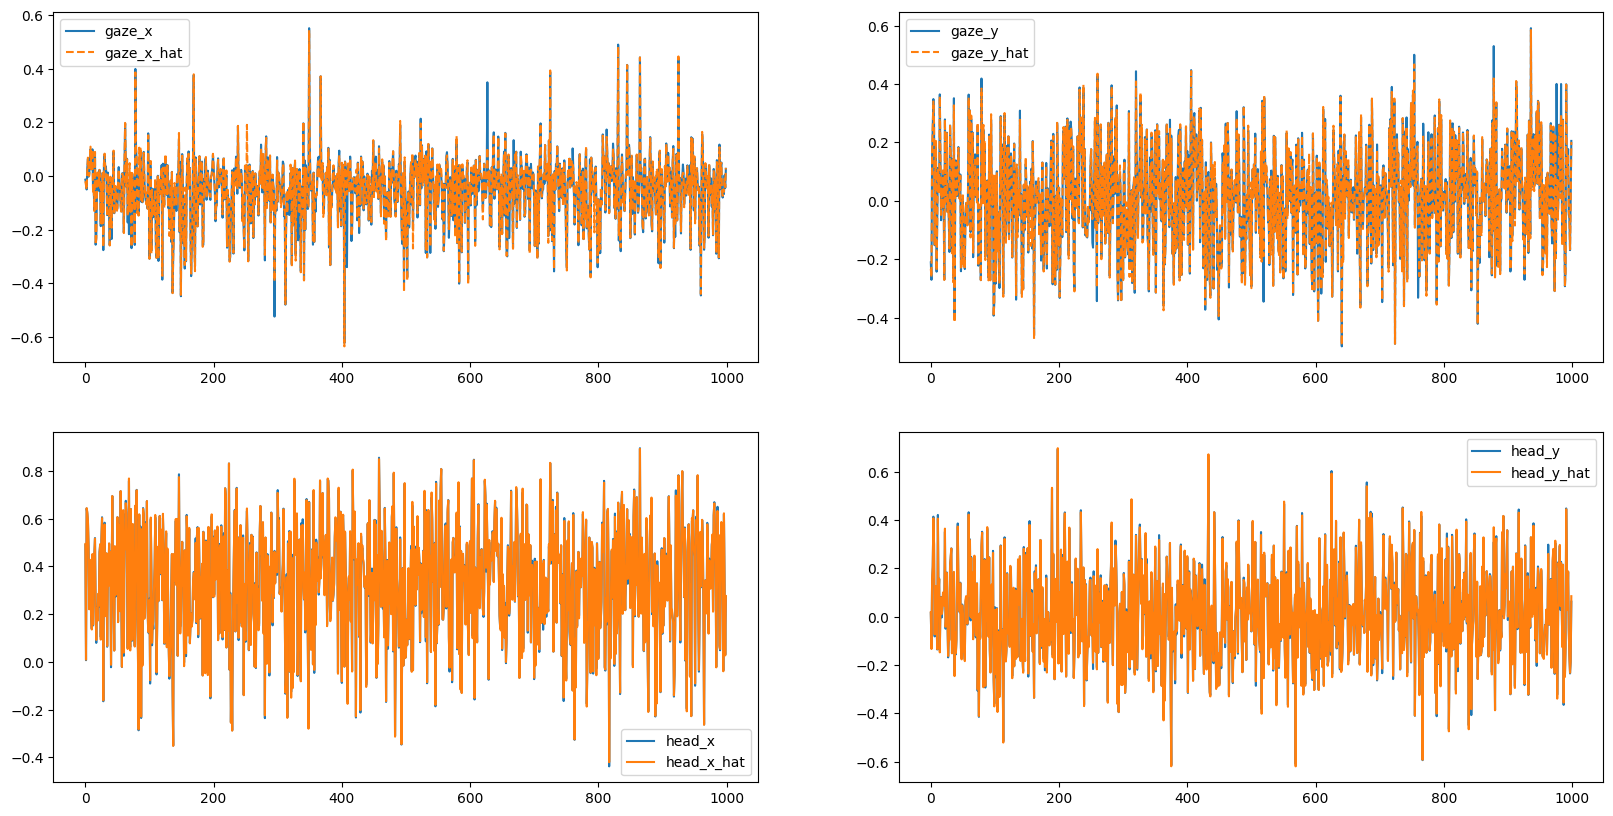

In [21]:
random_idx = np.random.randint(0, len(gazeCaptureDataset), 1000)
df = pd.DataFrame(columns=['gaze_x', 'gaze_x_hat', 'gaze_y', 'gaze_y_hat', 'head_x', 'head_x_hat', 'head_y', 'head_y_hat'])
for j, i in enumerate(random_idx):
    sample = gazeCaptureDataset[i]
    img = sample['image_a'].unsqueeze(0)
    gaze = sample['gaze_a'].numpy()
    head = sample['head_a'].numpy()
    gaze_hat, head_hat, _ = test_model(img, feature_out_layers=None)
    gaze_hat = gaze_hat.squeeze(0).detach().numpy()
    head_hat = head_hat.squeeze(0).detach().numpy()
    df.loc[j] = [gaze[0], gaze_hat[0], gaze[1], gaze_hat[1], head[0], head_hat[0], head[1], head_hat[1]]



import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(df['gaze_x'], label='gaze_x')
plt.plot(df['gaze_x_hat'], label='gaze_x_hat', linestyle='--')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(df['gaze_y'], label='gaze_y')
plt.plot(df['gaze_y_hat'], label='gaze_y_hat', linestyle='--')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(df['head_x'], label='head_x')
plt.plot(df['head_x_hat'], label='head_x_hat')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(df['head_y'], label='head_y')
plt.plot(df['head_y_hat'], label='head_y_hat')
plt.legend()

assuming reduction is None


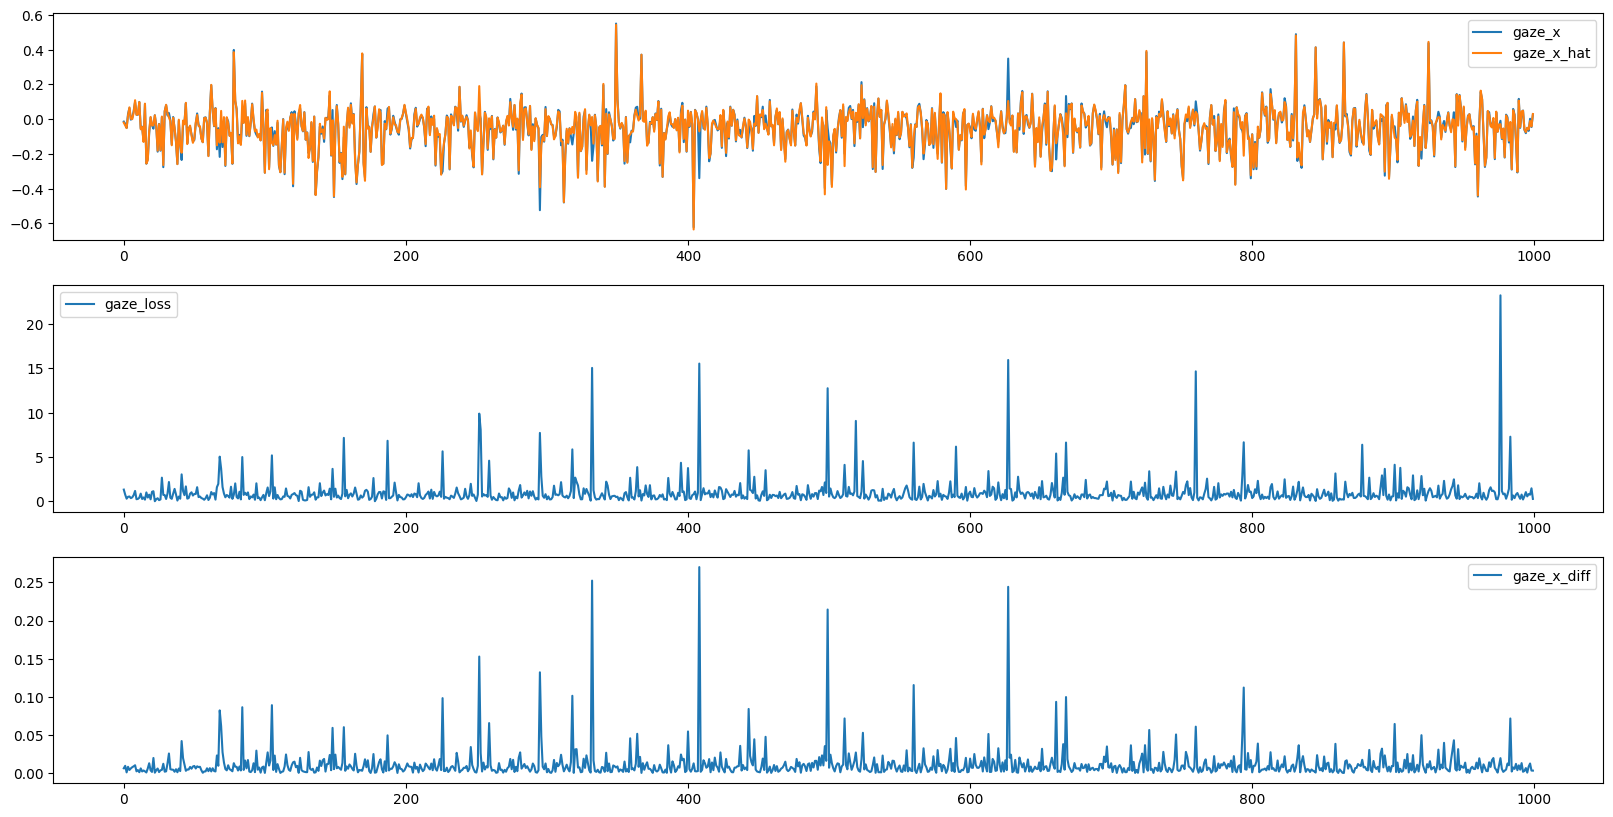

In [22]:
gaze_truth = torch.tensor(df[['gaze_x', 'gaze_y']].values)
gaze_hat = torch.tensor(df[['gaze_x_hat', 'gaze_y_hat']].values)
gaze_losses = gaze_angular_loss(gaze_truth, gaze_hat, reduction=None)
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(df['gaze_x'], label='gaze_x')
plt.plot(df['gaze_x_hat'], label='gaze_x_hat')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(gaze_losses, label='gaze_loss')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(np.abs(df['gaze_x'] - df['gaze_x_hat']), label='gaze_x_diff')
plt.legend()